In [8]:
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.6 MB/s eta 0:00:00


In [38]:
# !pip install -q git+https://github.com/gmihaila/ml_things.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.2 MB/s eta 0:00:00


In [ ]:
# Check that we have a GPU
!nvidia-smi

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import torch
import IPython
from torch.utils.data import Dataset
from tokenizers.processors import BertProcessing
from transformers import DataCollatorForLanguageModeling 
from transformers import Trainer, TrainingArguments
from pathlib import Path
from transformers import BertConfig, BertForMaskedLM , BertTokenizer
#! pip install tokenizers

from pathlib import Path
from tokenizers import  BertWordPieceTokenizer



In [10]:
from transformers import pipeline


In [65]:
from sklearn.model_selection import train_test_split
import math
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from ml_things import plot_dict, fix_text
import warnings
warnings.filterwarnings("ignore")


In [14]:
%cd  "/content/drive/MyDrive/am_lang_model"

/content/drive/MyDrive/am_lang_model


In [15]:
paths = ["/content/drive/MyDrive/am_lang_model/amwiki.txt"]

# Initialize a tokenizer
tokenizer = BertWordPieceTokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=10_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

# Save files to disk
tokenizer.save_model("/content/drive/MyDrive/am_lang_model/logs", "am_bert")



['/content/drive/MyDrive/am_lang_model/logs/am_bert-vocab.txt']

In [16]:
device = torch.device("cuda")

In [17]:
class AmharicTextDataset(Dataset):
    def __init__(self):
        tokenizer = BertTokenizer.from_pretrained(
            "/content/drive/MyDrive/am_lang_model/logs/am_bert-vocab.txt",max_len = 128
        )
        self.examples = []
        src_files  = [Path ("/content/drive/MyDrive/am_lang_model/amwiki.txt")]


        for src_file in src_files:
            print("🙃", src_file)
            lines = src_file.read_text(encoding="utf-8").splitlines()
            for line in lines:
                 
                self.examples.append( tokenizer(line)["input_ids"][:128])
                
                    
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        # We’ll pad at the batch level.
        ids = [token for token in self.examples[i] if token is not None]
        return torch.tensor(ids)




In [18]:

# Load the dataset
dataset = AmharicTextDataset()

# Split the dataset into train and test sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig(vocab_size = dataset.tokenizer.vocab_size + 5)

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertForMaskedLM(configuration).to(device)

print(model.num_parameters())

data_collator = DataCollatorForLanguageModeling(
    tokenizer=dataset.tokenizer, mlm=True, mlm_probability=0.15
)








/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:1706: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


🙃 /content/drive/MyDrive/am_lang_model/amwiki.txt


Token indices sequence length is longer than the specified maximum sequence length for this model (3522 > 128). Running this sequence through the model will result in indexing errors


93736725


In [20]:
# Define the compute_metrics function to calculate the training and validation loss
def compute_metrics(eval_pred):
    training_loss = eval_pred.loss
    validation_loss = eval_pred.metrics['eval_loss']
    perplexity = math.exp(validation_loss)
    return {'training_loss': training_loss, 'validation_loss': validation_loss, 'validation_perplexity': perplexity}


training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/am_lang_model/logs/am_bert",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_gpu_train_batch_size=32,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
    evaluation_strategy='steps',  # Evaluate every logging_steps
    eval_steps=1000,  # Evaluate every 1000 steps
    logging_steps=1000,  # Log the training loss and validation loss every 1000 steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset, # Use train_dataset instead of the original dataset
    eval_dataset=test_dataset,  # Use test_dataset as the evaluation dataset
    compute_metrics=compute_metrics  # Pass the compute_metrics function
)

trainer.train()

trainer.save_model("./logs/am_bert")


Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


Step,Training Loss,Validation Loss
1000,7.943700,7.535371
2000,7.380000,7.090250
3000,7.084700,6.859478
4000,6.890600,6.727263
5000,6.777900,6.660551


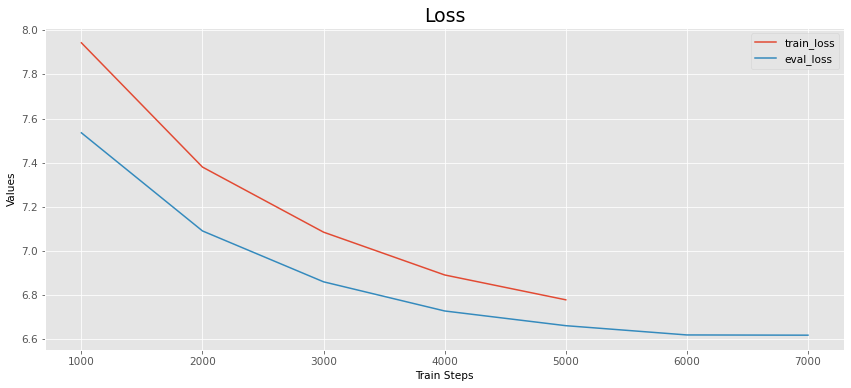

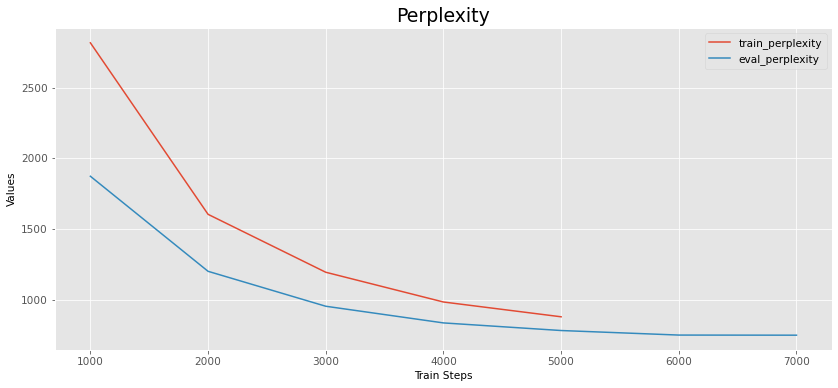

In [66]:
# Keep track of train and evaluate loss.
loss_history = {'train_loss':[], 'eval_loss':[]}

# Keep track of train and evaluate perplexity.
# This is a metric useful to track for language models.
perplexity_history = {'train_perplexity':[], 'eval_perplexity':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])
    perplexity_history['train_perplexity'].append(math.exp(log_history['loss']))
    
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])
    perplexity_history['eval_perplexity'].append(math.exp(log_history['eval_loss']))

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

print()

# Plot Perplexities.
plot_dict(perplexity_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Perplexity', 
          use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

In [41]:
if training_args.do_eval:
    # evaluate the model
    eval_output = trainer.evaluate()
    # calculate perplexity from the evaluation loss
    perplexity = math.exp(eval_output["eval_loss"])
    print("Perplexity: {}".format(perplexity))
else:
    print("No evaluation needed. `do_eval` is set to False.")


Perplexity: 748.8151268873253
